### Load required libraries

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load data

In [8]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z']

df = pd.read_csv('./data/HAR/WISDM/WISDM.csv', index_col=0)
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


### Inspect Data

In [9]:
df['activity'].value_counts(normalize=True)

Walking       0.386447
Jogging       0.311578
Upstairs      0.111882
Downstairs    0.091447
Sitting       0.054579
Standing      0.044067
Name: activity, dtype: float64

In [10]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z'], dtype='object')

### Data preprocessing

In [11]:
from pandas import DataFrame

sitting = df[df.activity=='Sitting'].sample(4499)
jogging = df[df.activity=='Jogging'].sample(4500)

sitting.iloc[:,1] = 0;
jogging.iloc[:,1] = 1;

sitting = sitting[['X','Y','Z', 'activity']]
jogging = jogging[['X','Y','Z', 'activity']]

resample = pd.concat([sitting, jogging])
resample = resample.sample(frac=1).reset_index(drop=True)
resample

,X,Y,Z,activity
0,-3.95,19.57,-9.575105,1
1,-7.16,-0.80,-6.850000,0
2,0.91,-0.11,9.700000,0
3,0.69,19.99,10.230000,1
4,5.90,2.41,7.780000,0
...,...,...,...,...
8994,-7.93,-7.89,-1.310000,1
8995,9.11,-1.38,1.950000,0
8996,-0.91,3.79,9.340000,0
8997,-3.83,3.49,8.580000,0


### Train/Test split

In [12]:
X_train, X_test = train_test_split(resample, test_size=0.2, random_state=42)
X_train = X_train[X_train.activity == 0]
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (3600, 3)
X_test shape: (1800, 3)


### Visualize the data with TSNE and PCA

In [13]:
x = resample.drop(['activity'],axis=1).values
y = resample['activity'].values

SEED = 42

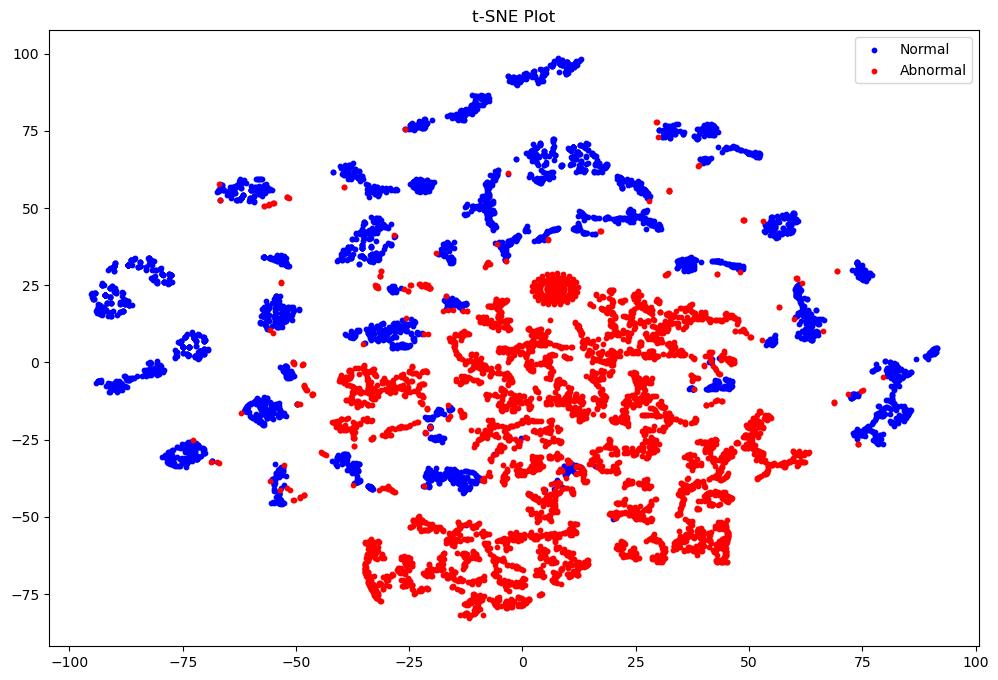

In [14]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal', s=10)
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Abnormal', s=10)
plt.title('t-SNE Plot')
plt.legend()
plt.show()

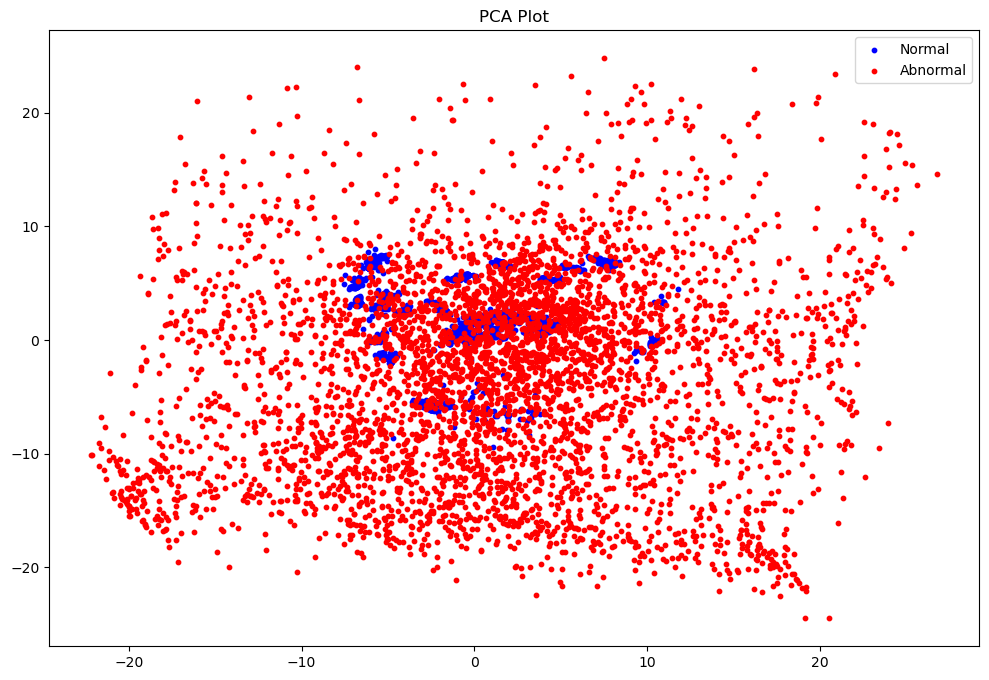

In [15]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal', s=10)
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Abnormal', s=10)
plt.title('PCA Plot')
plt.legend()
plt.show()

### Normalize Data

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### Add Noise into Data

In [17]:
noise_factor = 0.5;
X_train_noise = X_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

### Denoising AutoEncoder Model

In [18]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))

encoder = Dense(2, activation="relu")(input_layer)

decoder = Dense(input_dim)(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 2)                 8         
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
epochs = 200
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="./pth/WISDM_DAE.h5", verbose=0, save_best_only=True)

In [20]:
history = autoencoder.fit(X_train_noise, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/200
102/102 [==============================] - 3s 9ms/step - loss: 24.0447 - accuracy: 0.7787 - val_loss: 21.6055 - val_accuracy: 0.7083
Epoch 2/200
102/102 [==============================] - 0s 3ms/step - loss: 19.9695 - accuracy: 0.7068 - val_loss: 18.0705 - val_accuracy: 0.7250
Epoch 3/200
102/102 [==============================] - 0s 3ms/step - loss: 16.1027 - accuracy: 0.7762 - val_loss: 13.7902 - val_accuracy: 0.8417
Epoch 4/200
102/102 [==============================] - 0s 3ms/step - loss: 11.6424 - accuracy: 0.8389 - val_loss: 10.1519 - val_accuracy: 0.8444
Epoch 5/200
102/102 [==============================] - 0s 3ms/step - loss: 8.8351 - accuracy: 0.8404 - val_loss: 8.2770 - val_accuracy: 0.8500
Epoch 6/200
102/102 [==============================] - 0s 3ms/step - loss: 7.4083 - accuracy: 0.8451 - val_loss: 7.2639 - val_accuracy: 0.8528
Epoch 7/200
102/102 [==============================] - 0s 3ms/step - loss: 6.5721 - accuracy: 0.8568 - val_loss: 6.6006 - val_accuracy

Epoch 58/200
102/102 [==============================] - 0s 4ms/step - loss: 4.1798 - accuracy: 0.8910 - val_loss: 4.2411 - val_accuracy: 0.8889
Epoch 59/200
102/102 [==============================] - 0s 3ms/step - loss: 4.1714 - accuracy: 0.8920 - val_loss: 4.2307 - val_accuracy: 0.8889
Epoch 60/200
102/102 [==============================] - 0s 3ms/step - loss: 4.1620 - accuracy: 0.8917 - val_loss: 4.2224 - val_accuracy: 0.8889
Epoch 61/200
102/102 [==============================] - 0s 3ms/step - loss: 4.1524 - accuracy: 0.8904 - val_loss: 4.2103 - val_accuracy: 0.8889
Epoch 62/200
102/102 [==============================] - 0s 3ms/step - loss: 4.1451 - accuracy: 0.8920 - val_loss: 4.1999 - val_accuracy: 0.8889
Epoch 63/200
102/102 [==============================] - 0s 3ms/step - loss: 4.1355 - accuracy: 0.8914 - val_loss: 4.1902 - val_accuracy: 0.8889
Epoch 64/200
102/102 [==============================] - 0s 3ms/step - loss: 4.1267 - accuracy: 0.8920 - val_loss: 4.1843 - val_accuracy:

Epoch 115/200
102/102 [==============================] - 0s 3ms/step - loss: 3.8233 - accuracy: 0.8944 - val_loss: 3.8518 - val_accuracy: 0.8889
Epoch 116/200
102/102 [==============================] - 0s 3ms/step - loss: 3.8192 - accuracy: 0.8941 - val_loss: 3.8456 - val_accuracy: 0.8889
Epoch 117/200
102/102 [==============================] - 1s 6ms/step - loss: 3.8164 - accuracy: 0.8938 - val_loss: 3.8434 - val_accuracy: 0.8889
Epoch 118/200
102/102 [==============================] - 0s 3ms/step - loss: 3.8111 - accuracy: 0.8941 - val_loss: 3.8436 - val_accuracy: 0.8889
Epoch 119/200
102/102 [==============================] - 0s 3ms/step - loss: 3.8073 - accuracy: 0.8941 - val_loss: 3.8340 - val_accuracy: 0.8889
Epoch 120/200
102/102 [==============================] - 0s 3ms/step - loss: 3.8040 - accuracy: 0.8923 - val_loss: 3.8318 - val_accuracy: 0.8889
Epoch 121/200
102/102 [==============================] - 0s 3ms/step - loss: 3.8007 - accuracy: 0.8935 - val_loss: 3.8265 - val_ac

102/102 [==============================] - 0s 3ms/step - loss: 3.6641 - accuracy: 0.8954 - val_loss: 3.6879 - val_accuracy: 0.8889
Epoch 172/200
102/102 [==============================] - 0s 3ms/step - loss: 3.6630 - accuracy: 0.8951 - val_loss: 3.6893 - val_accuracy: 0.8889
Epoch 173/200
102/102 [==============================] - 0s 3ms/step - loss: 3.6609 - accuracy: 0.8957 - val_loss: 3.6849 - val_accuracy: 0.8889
Epoch 174/200
102/102 [==============================] - 0s 3ms/step - loss: 3.6607 - accuracy: 0.8954 - val_loss: 3.6805 - val_accuracy: 0.8889
Epoch 175/200
102/102 [==============================] - 0s 3ms/step - loss: 3.6557 - accuracy: 0.8963 - val_loss: 3.6807 - val_accuracy: 0.8889
Epoch 176/200
102/102 [==============================] - 0s 3ms/step - loss: 3.6558 - accuracy: 0.8957 - val_loss: 3.6802 - val_accuracy: 0.8889
Epoch 177/200
102/102 [==============================] - 0s 3ms/step - loss: 3.6550 - accuracy: 0.8951 - val_loss: 3.6776 - val_accuracy: 0.8889

In [21]:
autoencoder = load_model("./pth/WISDM_DAE.h5")

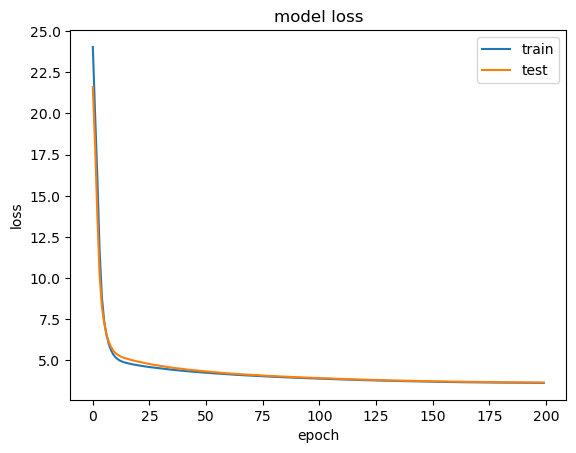

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [23]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

57/57 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,1800.000000,1800.000000
mean,21.731557,0.500556
std,35.965589,0.500139
min,0.000028,0.000000
25%,1.175837,0.000000
50%,3.975771,1.000000
75%,21.887467,1.000000
max,196.468197,1.000000


In [24]:
threshold = 13

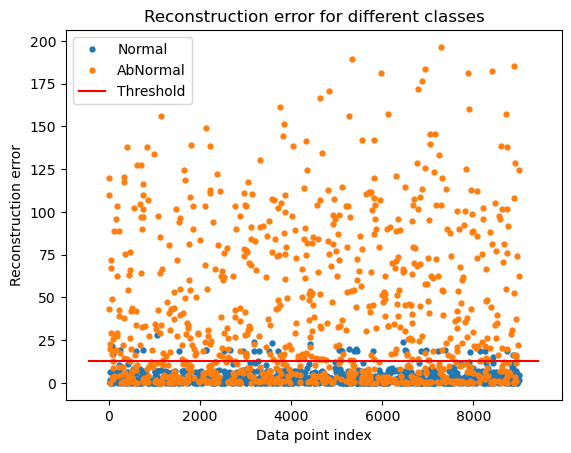

In [25]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "AbNormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

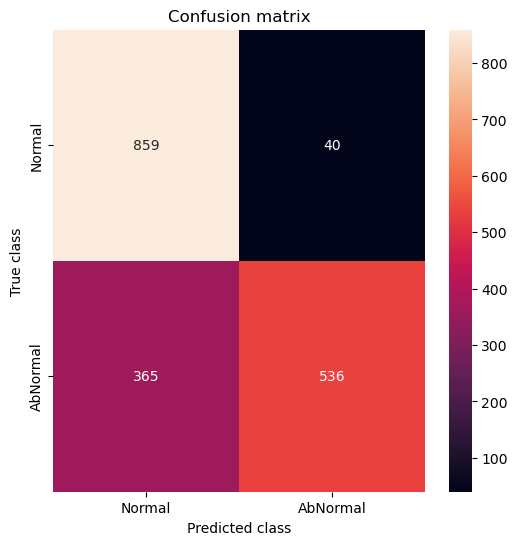

In [26]:
LABELS = ["Normal", "AbNormal"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [27]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.775
Precision : 0.9305555555555556
Recall : 0.5948945615982242
F1 : 0.7257955314827352


### Visualize the latent space

In [28]:
inp_layer = autoencoder.input
out_layer = autoencoder.layers[1].output

encoder = Model(inputs=inp_layer, outputs=out_layer)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 2)                 8         
                                                                 
Total params: 8 (32.00 Byte)
Trainable params: 8 (32.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


57/57 [==============================] - 0s 2ms/step


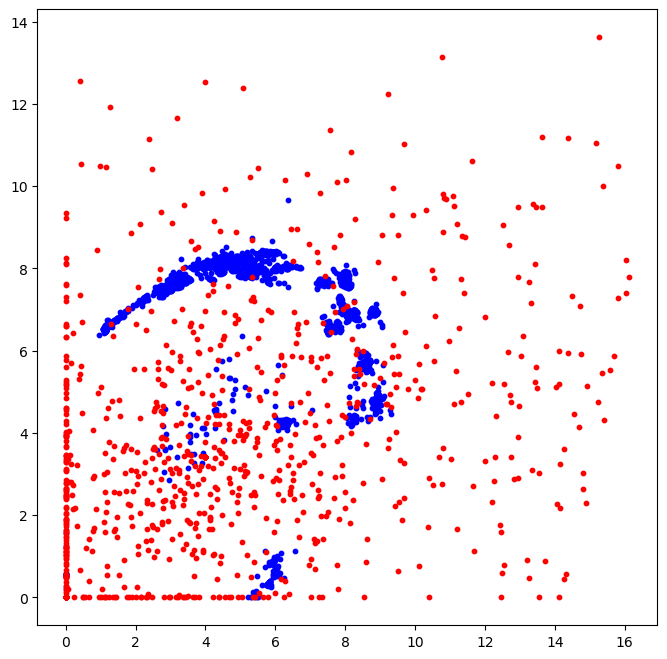

In [29]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[2]==0][0],encoded_df[encoded_df[2]==0][1], color='blue', label='Normal', s=10)
plt.scatter(encoded_df[encoded_df[2]==1][0],encoded_df[encoded_df[2]==1][1], color='red', label='AbNormal', s=10);